## **Chicago 311 - Exploratory Data Analysis**
---


![image.png](attachment:image.png)

This notebook presents an **Exploratory Data Analysis** of the Chicago 311 [official public data](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data), with the goals of:
- understanding and describing the dataset's main characteristics and behavioral patterns;
- provide analytical support for downstream modeling [notebooks]()

---


## **Context**


![image-2.png](attachment:image-2.png)

The **[Chicago 311 - Service Requests](https://311.chicago.gov/s/?language=en_US)** is the City of Chicago’s official system for **non-emergency service requests**.

It provides a single access point for residents, businesses, and visitors to *interact with city services*.

**Main purposes**
- Centralize citizen–city communication
- Reduce load on emergency services (911)
- Improve transparency and accountability
- Direct back-up facility for 911

---


### **How it works**
![image.png](attachment:image.png)
- Service Requests are submitted through different official channels
- Service Requests are routed to the correct city department
- Service Requests status and updates are informed

---


### **Service examples**
![image-3.png](attachment:image-3.png)

---


### **Data Value**
![image-4.png](attachment:image-4.png)
- High-volume, high-quality, spatial and time-stamped records
- Reflects real urban demand
- **[Daily Updated](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data)** -> will be used in a future **[ML Engineering Project]()**

---


### **Data Context**
---
![image-3.png](attachment:image-3.png)
- Data is available via file downloads and an API; **direct CSV downloads** were used for reproducibility.
- **Three years of data** were merged and converted into a **single Parquet file (~7.6M records)**.
- Due to dataset size, **pandas-based EDA can be slow or unstable**.
- **DuckDB with SQL and sampling** is used to enable fast, interactive exploration while preserving representativeness.
- Data ingestion and engineering steps are **out of scope** for this notebook.


## **Preparation**


### **Setting up**


In [ ]:
# Importing Python libraries
import numpy as np
from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geoviews as gv
import cartopy.crs as ccrs
from holoviews.operation.datashader import datashade
from colorcet import fire

#

In [45]:
# Initialize DuckDB database
con = duckdb.connect()
#

### **Loading the Data**


In [46]:
# Preview
# Sample dataset (random seeds)
df_sample = con.execute("""
SELECT *
FROM 'data/processed/data.parquet'
USING SAMPLE .1% -- random sample seeds
""").df()
df_sample
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,CREATED_DEPARTMENT,OWNER_DEPARTMENT,STATUS,ORIGIN,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,...,SANITATION_DIVISION_DAYS,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,__index_level_0__
0,SR24-01803817,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2024-09-25 17:47:12,2024-09-25 18:31:29,2024-09-25 17:47:13,...,None,17,4,9,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094043, -87.6798450000019)",759808
1,SR24-01803818,Garbage Cart Maintenance,SIE,None,Streets and Sanitation,Completed,Internet,2024-09-25 17:47:21,2024-10-07 13:03:12,2024-10-07 13:03:12,...,None,17,4,9,"1166882,887427198","1874169,7620524091","41,81029200094","-87,66342","(41.81029200094019, -87.66342000000192)",759809
2,SR24-01803819,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2024-09-25 17:47:27,2024-09-25 18:31:29,2024-09-25 17:47:37,...,None,17,4,9,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",759810
3,SR24-01803820,Tree Emergency,SEC,None,Streets and Sanitation,Completed,Mobile Device,2024-09-25 17:47:45,2024-09-26 07:33:47,2024-09-26 07:33:47,...,None,17,4,9,"1160274,6501126725","1945225,0361665967","42,00541200094","-87,6856905","(42.00541200094089, -87.68569050000191)",759811
4,SR24-01803821,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2024-09-25 17:47:47,2024-09-25 18:31:29,2024-09-25 17:47:47,...,None,17,4,9,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",759812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12283,SR25-00197466,Sign Repair Request - Stop Sign,PCB,311 City Services,CDOT - Department of Transportation,Completed,Phone Call,2025-02-06 09:09:34,2025-02-06 10:32:55,2025-02-06 10:32:55,...,None,9,5,2,"1164871,071881658","1925358,1782071735","41,95080000094","-87,6693465","(41.95080000094071, -87.66934650000191)",7917026
12284,SR25-00197468,Pothole in Street Complaint,PHF,CDOT - Department of Transportation,CDOT - Department of Transportation,Completed,Alderman's Office,2025-02-06 09:10:09,2025-02-07 15:07:10,2025-02-07 15:07:10,...,None,9,5,2,"1194248,36789545","1857985,6272603392","41,76525251129","-87,56357976897","(41.765252511286654, -87.56357976896676)",7917027
12285,SR25-00197469,Missed Garbage Pick-Up Complaint,SCC,None,Streets and Sanitation,Completed,Internet,2025-02-06 09:10:10,2025-02-06 12:40:06,2025-02-06 12:40:06,...,None,9,5,2,"1145313,2714173025","1931095,51739143","41,96693700094","-87,7410945","(41.96693700094076, -87.74109450000192)",7917028
12286,SR25-00197470,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2025-02-06 09:10:26,2025-02-06 09:32:19,2025-02-06 09:10:27,...,None,9,5,2,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",7917029


### **Preprocessing**


In [47]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].info()
#
# Type review
# 0 SR_NUMBER object ✅
# 1 SR_TYPE object ✅
# 2 SR_SHORT_CODE object ✅
# 3 CREATED_DEPARTMENT object ✅
# 4 OWNER_DEPARTMENT object ✅
# 5 STATUS object ✅
# 6 ORIGIN object ✅
# 7 CREATED_DATE object -> datetype ✅
# 8 LAST_MODIFIED_DATE object -> datetype ✅
# 9 CLOSED_DATE object -> datetype ✅
#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12288 entries, 0 to 12287
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SR_NUMBER           12288 non-null  object
 1   SR_TYPE             12288 non-null  object
 2   SR_SHORT_CODE       12288 non-null  object
 3   CREATED_DEPARTMENT  6928 non-null   object
 4   OWNER_DEPARTMENT    12288 non-null  object
 5   STATUS              12288 non-null  object
 6   ORIGIN              12288 non-null  object
 7   CREATED_DATE        12288 non-null  object
 8   LAST_MODIFIED_DATE  12288 non-null  object
 9   CLOSED_DATE         12134 non-null  object
dtypes: object(10)
memory usage: 960.1+ KB


In [48]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].head()
# Wrong type for date columns
#

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,CREATED_DEPARTMENT,OWNER_DEPARTMENT,STATUS,ORIGIN,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE
0,SR24-01803817,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2024-09-25 17:47:12,2024-09-25 18:31:29,2024-09-25 17:47:13
1,SR24-01803818,Garbage Cart Maintenance,SIE,None,Streets and Sanitation,Completed,Internet,2024-09-25 17:47:21,2024-10-07 13:03:12,2024-10-07 13:03:12
2,SR24-01803819,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2024-09-25 17:47:27,2024-09-25 18:31:29,2024-09-25 17:47:37
3,SR24-01803820,Tree Emergency,SEC,None,Streets and Sanitation,Completed,Mobile Device,2024-09-25 17:47:45,2024-09-26 07:33:47,2024-09-26 07:33:47
4,SR24-01803821,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2024-09-25 17:47:47,2024-09-25 18:31:29,2024-09-25 17:47:47


In [49]:
# Fixing types (1/4)
# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data AS
SELECT * REPLACE (
    CREATED_DATE ::TIMESTAMP AS CREATED_DATE,
    LAST_MODIFIED_DATE::TIMESTAMP AS LAST_MODIFIED_DATE,
    CLOSED_DATE ::TIMESTAMP AS CLOSED_DATE
)
FROM 'data/processed/data.parquet';
""")
# Update preview
df_sample = con.execute("""
SELECT * FROM data USING SAMPLE .1%
""").df()
# Pandas preview
df_sample[df_sample.columns[0:10]].info()
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12288 entries, 0 to 12287
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SR_NUMBER           12288 non-null  object        
 1   SR_TYPE             12288 non-null  object        
 2   SR_SHORT_CODE       12288 non-null  object        
 3   CREATED_DEPARTMENT  7164 non-null   object        
 4   OWNER_DEPARTMENT    12288 non-null  object        
 5   STATUS              12288 non-null  object        
 6   ORIGIN              12288 non-null  object        
 7   CREATED_DATE        12288 non-null  datetime64[us]
 8   LAST_MODIFIED_DATE  12288 non-null  datetime64[us]
 9   CLOSED_DATE         12105 non-null  datetime64[us]
dtypes: datetime64[us](3), object(7)
memory usage: 960.1+ KB


In [50]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].info()
#
# Type review
# 0 STREET_ADDRESS object ✅
# 1 CITY object ✅
# 2 STATE object ✅
# 3 ZIP_CODE object ✅
# 4 STREET_NUMBER object ✅
# 5 STREET_DIRECTION object ✅
# 6 STREET_NAME object ✅
# 7 STREET_TYPE object ✅
# 8 DUPLICATE object -> boolean ✅
# 9 LEGACY_RECORD object -> boolean ✅
#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12288 entries, 0 to 12287
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   STREET_ADDRESS    12284 non-null  object
 1   CITY              10462 non-null  object
 2   STATE             10462 non-null  object
 3   ZIP_CODE          10265 non-null  object
 4   STREET_NUMBER     12284 non-null  object
 5   STREET_DIRECTION  12284 non-null  object
 6   STREET_NAME       12284 non-null  object
 7   STREET_TYPE       12195 non-null  object
 8   DUPLICATE         12288 non-null  object
 9   LEGACY_RECORD     12288 non-null  object
dtypes: object(10)
memory usage: 960.1+ KB


In [51]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].head()
# 'DUPLICATE' and 'LEGACY_RECORDS' are boolean values
#

,STREET_ADDRESS,CITY,STATE,ZIP_CODE,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,DUPLICATE,LEGACY_RECORD
0,10510 W ZEMKE RD,Chicago,Illinois,60666.0,10510,W,ZEMKE,RD,False,False
1,2111 W Lexington ST,Chicago,Illinois,60612.0,2111,W,Lexington,ST,False,False
2,3480 W GRACE ST,Chicago,Illinois,60618.0,3480,W,GRACE,ST,False,False
3,10510 W ZEMKE RD,Chicago,Illinois,60666.0,10510,W,ZEMKE,RD,False,False
4,2111 W Lexington ST,Chicago,Illinois,60612.0,2111,W,Lexington,ST,False,False


In [52]:
# Fixing types (2/4)
# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data_2 AS
SELECT * REPLACE(
    LOWER(DUPLICATE) = 'true' AS DUPLICATE,
    LOWER(LEGACY_RECORD) = 'true' AS LEGACY_RECORD
)
FROM data;
""")
# Update preview
df_sample = con.execute("""
SELECT * FROM data_2 USING SAMPLE .1%
""").df()
# Pandas preview
df_sample[df_sample.columns[10:20]].info()
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   STREET_ADDRESS    6140 non-null   object
 1   CITY              4863 non-null   object
 2   STATE             4863 non-null   object
 3   ZIP_CODE          4797 non-null   object
 4   STREET_NUMBER     6140 non-null   object
 5   STREET_DIRECTION  6140 non-null   object
 6   STREET_NAME       6140 non-null   object
 7   STREET_TYPE       6089 non-null   object
 8   DUPLICATE         6144 non-null   bool  
 9   LEGACY_RECORD     6144 non-null   bool  
dtypes: bool(2), object(8)
memory usage: 396.1+ KB


In [53]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].info()
#
# Type review
# 0 LEGACY_SR_NUMBER object ✅
# 1 PARENT_SR_NUMBER object ✅
# 2 COMMUNITY_AREA object -> Int64 ✅
# 3 WARD object -> Int64 ✅
# 4 ELECTRICAL_DISTRICT object -> Int64 ✅
# 5 ELECTRICITY_GRID object ✅
# 6 POLICE_SECTOR object -> Int64 ✅
# 7 POLICE_DISTRICT object -> Int64 ✅
# 8 POLICE_BEAT object -> Int64 ✅
# 9 PRECINCT object -> Int64 ✅
#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   LEGACY_SR_NUMBER     0 non-null      object
 1   PARENT_SR_NUMBER     263 non-null    object
 2   COMMUNITY_AREA       6136 non-null   object
 3   WARD                 6136 non-null   object
 4   ELECTRICAL_DISTRICT  1858 non-null   object
 5   ELECTRICITY_GRID     4808 non-null   object
 6   POLICE_SECTOR        6135 non-null   object
 7   POLICE_DISTRICT      6135 non-null   object
 8   POLICE_BEAT          6135 non-null   object
 9   PRECINCT             6135 non-null   object
dtypes: object(10)
memory usage: 480.1+ KB


In [54]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].head()
# Some colunes are Integers
#

,LEGACY_SR_NUMBER,PARENT_SR_NUMBER,COMMUNITY_AREA,WARD,ELECTRICAL_DISTRICT,ELECTRICITY_GRID,POLICE_SECTOR,POLICE_DISTRICT,POLICE_BEAT,PRECINCT
0,None,None,25.0,37.0,6.0,D021,3.0,15.0,1532.0,30.0
1,None,None,49.0,9.0,None,P045,1.0,5.0,511.0,25.0
2,None,None,28.0,28.0,None,K024,2.0,12.0,1225.0,46.0
3,None,None,44.0,8.0,None,R044,3.0,6.0,633.0,15.0
4,None,None,76.0,41.0,None,None,5.0,16.0,1654.0,27.0


In [55]:
# Preview (3/4)
df_sample[['COMMUNITY_AREA', 'WARD', 'ELECTRICAL_DISTRICT', 'POLICE_SECTOR',
           'POLICE_DISTRICT', 'POLICE_BEAT', 'PRECINCT']]
# All integers
#

,COMMUNITY_AREA,WARD,ELECTRICAL_DISTRICT,POLICE_SECTOR,POLICE_DISTRICT,POLICE_BEAT,PRECINCT
0,25.0,37.0,6.0,3.0,15.0,1532.0,30.0
1,49.0,9.0,None,1.0,5.0,511.0,25.0
2,28.0,28.0,None,2.0,12.0,1225.0,46.0
3,44.0,8.0,None,3.0,6.0,633.0,15.0
4,76.0,41.0,None,5.0,16.0,1654.0,27.0
...,...,...,...,...,...,...,...
6139,7.0,43.0,5.0,1.0,18.0,1812.0,7.0
6140,5.0,47.0,4.0,2.0,19.0,1921.0,4.0
6141,28.0,28.0,7.0,2.0,12.0,1225.0,46.0
6142,28.0,28.0,7.0,2.0,12.0,1225.0,46.0


In [56]:
# Fixing types (3/4)
# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data_3 AS
SELECT * REPLACE(
    COMMUNITY_AREA ::BIGINT AS COMMUNITY_AREA,
    WARD ::BIGINT AS WARD,
    ELECTRICAL_DISTRICT ::BIGINT AS ELECTRICAL_DISTRICT,
    POLICE_SECTOR ::BIGINT AS POLICE_SECTOR,
    POLICE_DISTRICT ::BIGINT AS POLICE_DISTRICT,
    POLICE_BEAT ::BIGINT AS POLICE_BEAT,
    PRECINCT ::BIGINT AS PRECINCT
)
FROM data_2;
""")
# Update preview
df_sample = con.execute("""
SELECT * FROM data_3 USING SAMPLE .1%
""").df()
# Pandas preview
df_sample[df_sample.columns[20:30]].info()
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   LEGACY_SR_NUMBER     0 non-null      object
 1   PARENT_SR_NUMBER     103 non-null    object
 2   COMMUNITY_AREA       4094 non-null   Int64 
 3   WARD                 4095 non-null   Int64 
 4   ELECTRICAL_DISTRICT  1850 non-null   Int64 
 5   ELECTRICITY_GRID     3604 non-null   object
 6   POLICE_SECTOR        4092 non-null   Int64 
 7   POLICE_DISTRICT      4092 non-null   Int64 
 8   POLICE_BEAT          4092 non-null   Int64 
 9   PRECINCT             4092 non-null   Int64 
dtypes: Int64(7), object(3)
memory usage: 348.1+ KB


In [57]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]].info()
#
# Type review
# 0 SANITATION_DIVISION_DAYS object -> drop ✅
# 1 CREATED_HOUR object -> Int64 ✅
# 2 CREATED_DAY_OF_WEEK object -> Int64 ✅
# 3 CREATED_MONTH object -> Int64 ✅
# 4 X_COORDINATE object -> Float64 ✅
# 5 Y_COORDINATE object -> Float64 ✅
# 6 LATITUDE object -> Float64 ✅
# 7 LONGITUDE object -> Float64 ✅
# 8 LOCATION object ✅
#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   SANITATION_DIVISION_DAYS  0 non-null      object
 1   CREATED_HOUR              4096 non-null   object
 2   CREATED_DAY_OF_WEEK       4096 non-null   object
 3   CREATED_MONTH             4096 non-null   object
 4   X_COORDINATE              4095 non-null   object
 5   Y_COORDINATE              4095 non-null   object
 6   LATITUDE                  4092 non-null   object
 7   LONGITUDE                 4092 non-null   object
 8   LOCATION                  4092 non-null   object
 9   __index_level_0__         4096 non-null   int64 
dtypes: int64(1), object(9)
memory usage: 320.1+ KB


In [58]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]]
#

,SANITATION_DIVISION_DAYS,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,__index_level_0__
0,None,9,4,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",96256
1,None,9,4,11,"1170652,807221318","1903751,7758077858","41,89138606704","-87,64872739414","(41.891386067035, -87.648727394141)",96257
2,None,9,4,11,"1167841,6004760738","1852934,4100633978","41,75199900094","-87,660513","(41.75199900094, -87.660513000002)",96258
3,None,9,4,11,"1135634,586926777","1947350,8256677645","42,01172100094","-87,7762935","(42.011721000941, -87.776293500002)",96259
4,None,9,4,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",96260
...,...,...,...,...,...,...,...,...,...,...
4091,None,22,7,11,"1144537,9140273626","1897308,6228782104","41,87423700094","-87,744798","(41.87423700094042, -87.74479800000192)",3051698
4092,None,22,7,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094043, -87.6798450000019)",3051699
4093,None,22,7,11,"1144378,3452582217","1897701,0975192164","41,87531700094","-87,745374","(41.875317000940434, -87.74537400000192)",3051700
4094,None,22,7,11,"1150859,231711626","1928264,687311486","41,95906200094","-87,720777","(41.959062000940754, -87.72077700000192)",3051701


In [59]:
# Preview (4/4)
df_sample['SANITATION_DIVISION_DAYS'].unique()[:10]
# Empty
#

array([None], dtype=object)

In [60]:
# Excluding 'SANITATION_DIVISION_DAYS' column
con.execute("""
CREATE OR REPLACE VIEW data_4 AS
SELECT * EXCLUDE (SANITATION_DIVISION_DAYS)
FROM data_3;
""")
# Update preview
df_sample = con.execute("""
SELECT * FROM data_4 USING SAMPLE .1%
""").df()
df_sample
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,CREATED_DEPARTMENT,OWNER_DEPARTMENT,STATUS,ORIGIN,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,...,PRECINCT,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,__index_level_0__
0,SR23-01215106,Street Light Out Complaint,SFD,311 City Services,CDOT - Department of Transportation,Completed,Phone Call,2023-07-25 23:39:27,2023-07-28 06:21:45,2023-07-28 06:21:45,...,26,23,3,7,"1165268,618100054","1916017,214582189","41,92515943943","-87,66815157989","(41.925159439433656, -87.66815157988582)",2494647
1,SR23-01215108,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2023-07-25 23:39:55,2023-07-26 00:30:40,2023-07-25 23:39:55,...,27,23,3,7,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",2494648
2,SR23-01215109,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2023-07-25 23:40:20,2023-07-26 00:30:40,2023-07-25 23:40:21,...,27,23,3,7,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",2494649
3,SR23-01215110,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2023-07-25 23:40:25,2023-07-26 00:30:40,2023-07-25 23:40:26,...,27,23,3,7,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",2494650
4,SR23-01215111,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2023-07-25 23:40:30,2023-07-26 00:30:40,2023-07-25 23:40:30,...,27,23,3,7,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",2494651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,SR23-01748604,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2023-10-10 15:48:38,2023-10-10 16:30:40,2023-10-10 15:48:38,...,46,15,3,10,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094043, -87.6798450000019)",2920626
6140,SR23-01748605,Abandoned Vehicle Complaint,SKA,None,Streets and Sanitation,Completed,Mobile Device,2023-10-10 15:48:57,2023-11-04 04:06:29,2023-11-04 04:06:28,...,28,15,3,10,"1150465,5014337236","1894316,253258191","41,86591200094","-87,7231125","(41.865912000940405, -87.72311250000193)",2920627
6141,SR23-01748609,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2023-10-10 15:49:28,2023-10-10 16:30:40,2023-10-10 15:49:28,...,46,15,3,10,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094043, -87.6798450000019)",2920628
6142,SR23-01748610,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2023-10-10 15:49:31,2023-10-10 16:30:59,2023-10-10 15:49:31,...,46,15,3,10,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094043, -87.6798450000019)",2920629


In [61]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]].info()
#
# Type review
# 0 CREATED_HOUR 10000 non-null object -> int64 ✅
# 1 CREATED_DAY_OF_WEEK 10000 non-null object -> int64 ✅
# 2 CREATED_MONTH 10000 non-null object -> int64 ✅
# 3 X_COORDINATE 9997 non-null object -> float64 ✅
# 4 Y_COORDINATE 9997 non-null object -> float64 ✅
# 5 LATITUDE 9997 non-null object -> float64 ✅
# 6 LONGITUDE 9997 non-null object -> float64 ✅
# 7 LOCATION 9997 non-null object ✅
#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CREATED_HOUR         6144 non-null   object
 1   CREATED_DAY_OF_WEEK  6144 non-null   object
 2   CREATED_MONTH        6144 non-null   object
 3   X_COORDINATE         6141 non-null   object
 4   Y_COORDINATE         6141 non-null   object
 5   LATITUDE             6140 non-null   object
 6   LONGITUDE            6140 non-null   object
 7   LOCATION             6140 non-null   object
 8   __index_level_0__    6144 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 432.1+ KB


In [62]:
# Fixing types (4/4)
# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data_5 AS
SELECT * REPLACE(
    CREATED_HOUR ::BIGINT AS CREATED_HOUR,
    CREATED_DAY_OF_WEEK ::BIGINT AS CREATED_DAY_OF_WEEK,
    CREATED_MONTH ::BIGINT AS CREATED_MONTH,
    regexp_replace(X_COORDINATE, ',', '.', 'g')::DOUBLE AS X_COORDINATE,
    regexp_replace(Y_COORDINATE, ',', '.', 'g')::DOUBLE AS Y_COORDINATE,
    regexp_replace(LATITUDE, ',', '.', 'g')::DOUBLE AS LATITUDE,
    regexp_replace(LONGITUDE, ',', '.', 'g')::DOUBLE AS LONGITUDE
)
FROM data_4;
""")
# Update preview
df_sample = con.execute("""
SELECT * FROM data_5 USING SAMPLE .1%
""").df()
# Pandas preview
df_sample[df_sample.columns[30:40]].info()
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14336 entries, 0 to 14335
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CREATED_HOUR         14336 non-null  int64  
 1   CREATED_DAY_OF_WEEK  14336 non-null  int64  
 2   CREATED_MONTH        14336 non-null  int64  
 3   X_COORDINATE         14328 non-null  float64
 4   Y_COORDINATE         14328 non-null  float64
 5   LATITUDE             14326 non-null  float64
 6   LONGITUDE            14326 non-null  float64
 7   LOCATION             14326 non-null  object 
 8   __index_level_0__    14336 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 1008.1+ KB


## **Exploratory Data Analysis**


#### **Structure Overview**


In [63]:
# Shape
con.execute("""SELECT * FROM data_5""").df().shape
# read and discard the object
# 7645761 rows x 39 columns
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(7645761, 39)

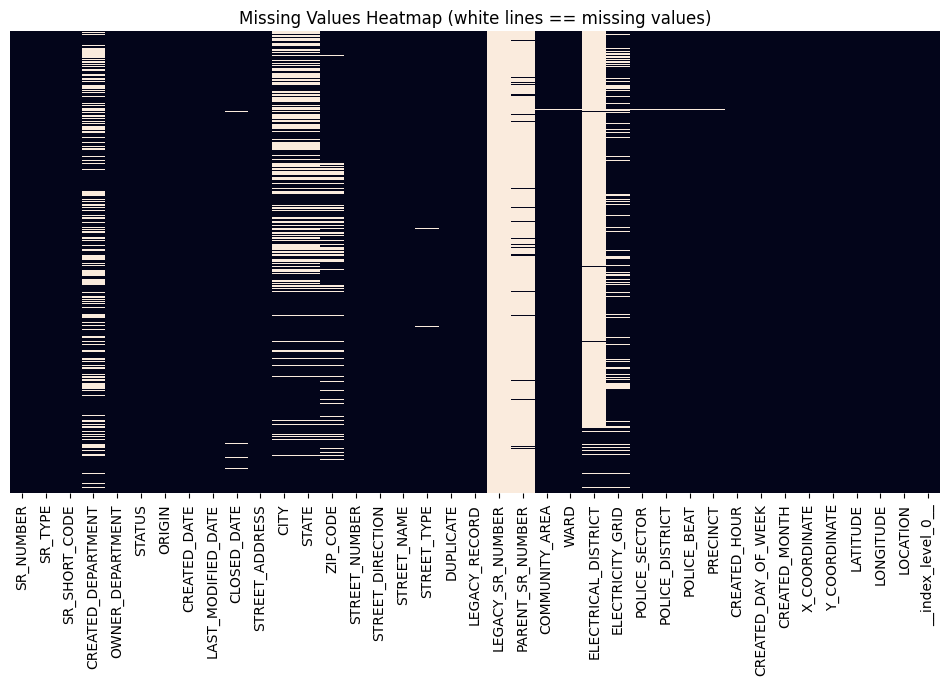

In [64]:
# Vizualizing missing data with sampling
df_sample = df_sample.sort_values("CREATED_DATE")
plt.figure(figsize=(12, 6))
sns.heatmap(df_sample.isna(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap (white lines == missing values)')
plt.show()
# white lines -> missing values
#

In [65]:
# High missingess %
(df_sample.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)
# High missingess columns:
# Unusable! (>60%)
# ==================
# LEGACY_SR_NUMBER
# PARENT_SR_NUMBER
# ELECTRICAL_DISTRICT
# "Repairable" if necessary
# ==================
# CREATED_DEPARTMENT
# STATE
# CITY
# ELETRICITY_GRID
# ZIP_CODE
#

LEGACY_SR_NUMBER       100.00
PARENT_SR_NUMBER        95.91
ELECTRICAL_DISTRICT     86.20
CREATED_DEPARTMENT      40.21
STATE                   32.37
CITY                    32.37
ELECTRICITY_GRID        17.03
ZIP_CODE                16.49
CLOSED_DATE              1.31
STREET_TYPE              0.85
STREET_NUMBER            0.16
STREET_DIRECTION         0.16
PRECINCT                 0.12
POLICE_SECTOR            0.10
POLICE_BEAT              0.10
POLICE_DISTRICT          0.10
COMMUNITY_AREA           0.10
WARD                     0.10
LOCATION                 0.07
LATITUDE                 0.07
LONGITUDE                0.07
STREET_NAME              0.06
STREET_ADDRESS           0.06
X_COORDINATE             0.06
Y_COORDINATE             0.06
dtype: float64

In [66]:
# Excluding columnS
con.execute("""
CREATE OR REPLACE VIEW data_6 AS
SELECT * EXCLUDE(LEGACY_SR_NUMBER, PARENT_SR_NUMBER, ELECTRICAL_DISTRICT)
FROM data_5;
""")
df_sample = con.execute("""
SELECT * FROM data_6 USING SAMPLE .1%
""").df()
(df_sample.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CREATED_DEPARTMENT    35.66
CITY                  33.18
STATE                 33.18
ZIP_CODE              25.22
ELECTRICITY_GRID      16.66
CLOSED_DATE            2.09
STREET_TYPE            0.81
COMMUNITY_AREA         0.13
PRECINCT               0.13
WARD                   0.09
POLICE_DISTRICT        0.09
POLICE_BEAT            0.09
POLICE_SECTOR          0.09
STREET_DIRECTION       0.05
LONGITUDE              0.02
X_COORDINATE           0.02
LOCATION               0.02
STREET_NAME            0.02
STREET_ADDRESS         0.02
STREET_NUMBER          0.02
Y_COORDINATE           0.02
LATITUDE               0.02
SR_NUMBER              0.00
SR_TYPE                0.00
SR_SHORT_CODE          0.00
dtype: float64

#### **Categorical Columns Analysis**


In [67]:
con.execute("""
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'data_6' AND data_type = 'VARCHAR'
""").df()
# Our Focus:
# SR_TYPE
# CREATED_DEPARTMENT
# OWNER_DEPARTMENT
# STATUS
# ORIGIN
# CITY
# STATE
#

,column_name,data_type
0,SR_NUMBER,VARCHAR
1,SR_TYPE,VARCHAR
2,SR_SHORT_CODE,VARCHAR
3,CREATED_DEPARTMENT,VARCHAR
4,OWNER_DEPARTMENT,VARCHAR
5,STATUS,VARCHAR
6,ORIGIN,VARCHAR
7,STREET_ADDRESS,VARCHAR
8,CITY,VARCHAR
9,STATE,VARCHAR


##### **SR_TYPE**


In [68]:
# SR_TYPE top 20
(df_sample['SR_TYPE']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
# Information only + Aircraft noise - dominate the distribution
#

SR_TYPE
311 INFORMATION ONLY CALL                41.86
Aircraft Noise Complaint                 16.48
Graffiti Removal Request                  4.64
Pothole in Street Complaint               3.91
Street Light Out Complaint                3.32
Abandoned Vehicle Complaint               2.58
Water Lead Test Kit Request               2.10
Garbage Cart Maintenance                  2.10
Rodent Baiting/Rat Complaint              1.54
Traffic Signal Out Complaint              1.20
Blue Recycling Cart                       1.06
Stray Animal Complaint                    0.95
Building Violation                        0.93
Ice and Snow Removal Request              0.85
Alley Pothole Complaint                   0.78
Sign Repair Request - All Other Signs     0.71
Dead Animal Pick-Up Request               0.68
Tree Debris Clean-Up Request              0.68
Tree Removal Inspection                   0.67
Check for Leak                            0.57
Name: proportion, dtype: float64

In [69]:
# Possible rare yet high SLA impact event examples
long_tail = con.execute("""
SELECT
    SR_TYPE,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct
FROM data_6
WHERE CREATED_DATE IS NOT NULL
  AND CLOSED_DATE IS NOT NULL
  AND SR_TYPE NOT ILIKE '%tree%'
GROUP BY SR_TYPE
ORDER BY avg_days_open DESC, pct DESC
LIMIT 20;
""").df()
long_tail
# Tree-related requests dominate counts due to semantic grouping,
# so they are excluded to highlight other high-SLA-impact categories.
#

,SR_TYPE,avg_days_open,pct
0,Sidewalk Inspection Request,693.61,0.28
1,Shared Cost Sidewalk Program Request,655.79,0.05
2,Protected Bike Lane - Debris Removal,351.57,0.01
3,Viaduct Light Out Complaint,199.06,0.02
4,Sign Repair Request - All Other Signs,182.18,0.69
5,No Building Permit and Construction Violation,160.46,0.27
6,Bicycle Request/Complaint,153.49,0.04
7,Paid Sick Leave Violation,142.73,0.01
8,Licensed Pharmaceutical Representative Complaint,119.74,0.00
9,Wage Complaint,82.50,0.01


##### **CREATED_DEPARTMENT**


In [70]:
# CREATED_DEPARTMENT top 20
(df_sample['CREATED_DEPARTMENT']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
# 311 City Services dominates the distribution
#

CREATED_DEPARTMENT
311 City Services                       87.33
Alderman                                 5.77
CDOT - Department of Transportation      3.32
Streets and Sanitation                   3.13
DWM - Department of Water Management     0.32
Animal Care and Control                  0.06
DOB - Buildings                          0.04
Health                                   0.04
Name: proportion, dtype: float64

##### **OWNER_DEPARTMENT**


In [71]:
# OWNER_DEPARTMENT top 20
(df_sample['OWNER_DEPARTMENT']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
# 311 City Services + Aviation - Still dominant
# Streets and Sanitation + CDOT - Appears with high frequency now (possibly after misplacement fix?)
#

OWNER_DEPARTMENT
311 City Services                                  41.86
Streets and Sanitation                             18.49
Aviation                                           16.48
CDOT - Department of Transportation                12.83
DWM - Department of Water Management                4.54
Animal Care and Control                             2.20
DOB - Buildings                                     2.09
BACP - Business Affairs and Consumer Protection     0.74
City Clerk's Office                                 0.28
Finance                                             0.18
Health                                              0.18
Outside Agencies                                    0.09
Department of Housing                               0.02
Fire                                                0.01
Name: proportion, dtype: float64

##### **STATUS**


In [72]:
# STATUS top 20
(df_sample['STATUS']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
# >90% of requests are marked as "Completed".
# closure may be driven by automatic rules or operational workflows,
# which could bias SLA/time-to-close modeling and class imbalance.
#

STATUS
Completed    96.58
Open          2.09
Canceled      1.33
Name: proportion, dtype: float64

In [73]:
# Top Not completed
not_completed = con.execute("""
SELECT
    SR_TYPE,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open
FROM data_6
WHERE CREATED_DATE IS NOT NULL
  AND CLOSED_DATE IS NOT NULL
  AND STATUS != 'Completed'
GROUP BY SR_TYPE
ORDER BY pct DESC, avg_days_open DESC
LIMIT 20;
""").df()
not_completed
# Stray Animal: unresolved/unsuccessful capture ?
# Water and Tree related categories dominate operational workload even outside "Completed".
#

,SR_TYPE,pct,avg_days_open
0,Stray Animal Complaint,23.85,9.37
1,Tree Debris Clean-Up Request,9.30,4.07
2,Tree Removal Inspection,7.27,77.58
3,Check for Leak,5.12,0.95
4,Water Lead Test Kit Request,4.74,14.25
5,No Water Complaint,4.08,0.14
6,Report an Injured Animal,4.03,0.69
7,Open Fire Hydrant Complaint,3.14,0.27
8,Water On Street Complaint,2.96,1.03
9,Water in Basement Complaint,2.78,1.02


##### **ORIGIN**


In [74]:
# ORIGIN top 20
(df_sample['ORIGIN']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
#

ORIGIN
Phone Call                    60.53
Internet                      25.81
Mobile Device                  8.24
Alderman's Office              3.50
Mass Entry                     1.06
Salesforce Mobile App          0.27
DWM                            0.20
SPOTCSR                        0.16
Generated In House             0.10
spot-open311-Chicago+Works     0.10
E-Mail                         0.02
spot-open311-SeeClickFix       0.01
Name: proportion, dtype: float64

In [75]:
# Rare yet High impact events (long tail)
long_tail = con.execute("""
SELECT
    ORIGIN,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct
FROM data_6
WHERE CREATED_DATE IS NOT NULL
  AND CLOSED_DATE IS NOT NULL
GROUP BY ORIGIN
ORDER BY avg_days_open DESC, pct DESC;
""").df()
long_tail
# Legacy methods are very slow yet very rare
# E-mail, though modern, is slow and rare as mail
# Walking-in beats a State Representative by almost a week!
# A phone call is probably the most reliable way to register a complain!
#

,ORIGIN,avg_days_open,pct
0,Fax,86.24,0.00
1,Mail,63.46,0.00
2,E-Mail,63.29,0.03
3,Open311 Interface,56.67,0.00
4,spot-open311-Chicago+Works,48.68,0.06
5,Alderman's Office,47.42,3.36
6,State Representatives,41.85,0.00
7,spot-open311-SeeClickFix,35.98,0.03
8,DWM,35.49,0.24
9,Walk-in,35.23,0.01


#### **Time/Date Columns Analysis**


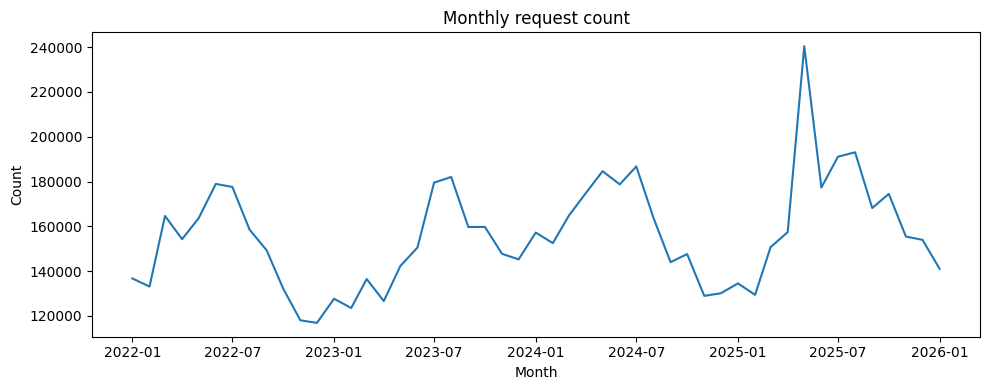

In [76]:
df_month = con.execute("""
SELECT
    DATE_TRUNC('month', CREATED_DATE) AS month,
    COUNT(*) AS n
FROM data_6
GROUP BY 1
ORDER BY 1
""").df()

plt.figure(figsize=(10, 4))
plt.plot(df_month["month"], df_month["n"])
plt.title("Monthly request count")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Series shows higher counts in the middle of the year
# Lower counts at the start/end of the year
# Might indicates sazonality
# Annual maximum and minimum counts have been increasing since 2022
#

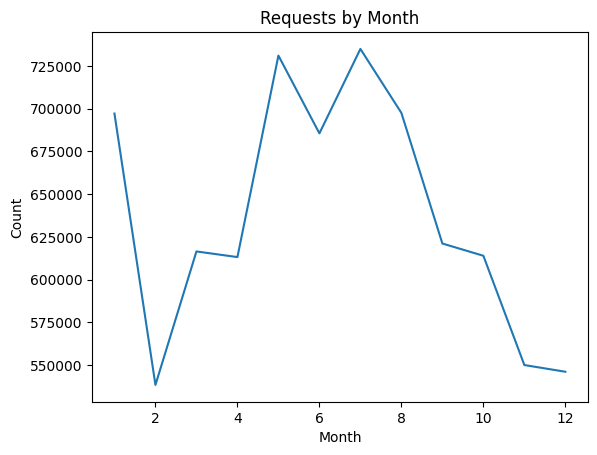

In [77]:
# Requests by month
df_month = con.execute("""
SELECT CREATED_MONTH, COUNT(*) AS n
FROM data_6
GROUP BY CREATED_MONTH
ORDER BY CREATED_MONTH
""").df()

df_month.plot(x="CREATED_MONTH", y="n", legend=False)
plt.title("Requests by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

# November to February -> lowest requests counts
# May to August -> highest requests counts
#

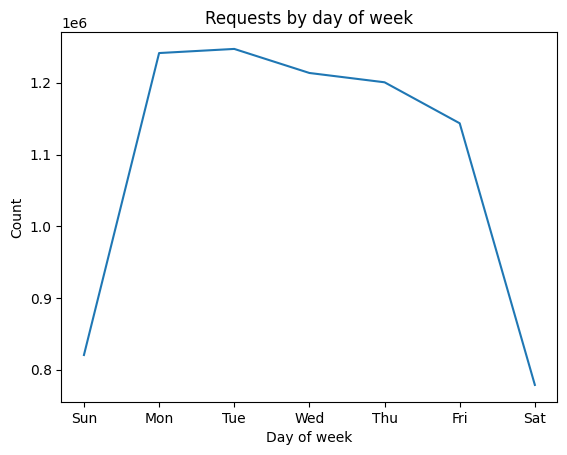

In [78]:
# Requests by day of week (1=Sunday ... 7=Saturday)
df_dow = con.execute("""
SELECT CREATED_DAY_OF_WEEK, COUNT(*) AS n
FROM data_6
GROUP BY 1
ORDER BY 1
""").df()

ax = df_dow.plot(x="CREATED_DAY_OF_WEEK", y="n", legend=False)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
ax.set_title("Requests by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Count")
plt.show()
# Most of request volumes in work days
#

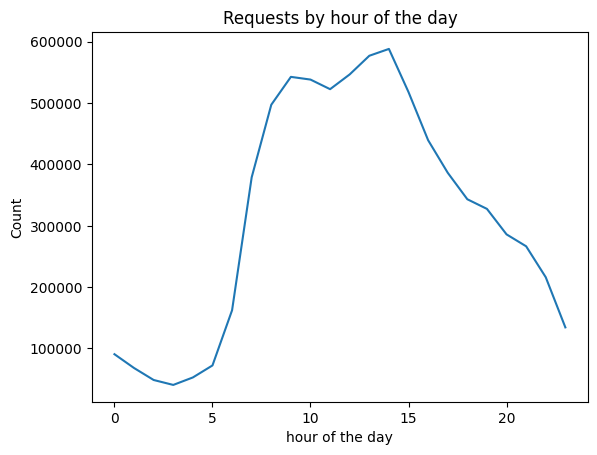

In [79]:
# Requests by hour of the day
df_hour = con.execute("""
SELECT CREATED_HOUR, COUNT(*) AS n
FROM data_6
GROUP BY CREATED_HOUR
ORDER BY CREATED_HOUR
""").df()

df_hour.plot(x="CREATED_HOUR", y="n", legend=False)
plt.title("Requests by hour of the day")
plt.xlabel("hour of the day")
plt.ylabel("Count")
plt.show()
# Most of requests in work hours
#

#### **Spatial Columns Analysis**


In [80]:
# % valid coordinates
stats = con.execute("""
SELECT
    COUNT(*) AS n_total,
    COUNT(*) FILTER (
        WHERE latitude BETWEEN -90 AND 90
          AND longitude BETWEEN -180 AND 180
    ) AS n_valid
FROM data_6
""").df()
stats["pct_valid"] = stats["n_valid"] / stats["n_total"]
stats["pct_valid"]
# almost 100%
#

0    0.99945
Name: pct_valid, dtype: float64

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
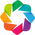

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'32971d4d-87d5-4336-8b88-3e105b8c4bec': {'version…

In [81]:
gv.extension("bokeh")
df = con.execute("""
SELECT latitude AS lat, longitude AS lon
FROM data_6
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

(
    gv.tile_sources.CartoDark()
    * datashade(
        gv.Points(df, ["lon", "lat"]),
        cmap="fire",
        width=600,
        height=600,
        expand=False
    )
).opts(width=400, height=400)
#

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
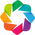

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'5e19b866-2a87-4bd1-a329-55c9411b6559': {'version…

In [82]:
# Service Requests Density
gv.extension("bokeh")
df = con.execute("""
SELECT latitude AS lat, longitude AS lon
FROM data_6
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

points = gv.Points(df, ["lon", "lat"])
shaded = datashade(points, width=1200, height=1200, cmap=fire, cnorm='eq_hist')
(gv.tile_sources.CartoDark * shaded).opts(width=400, height=400)

# Service requests are denser in the north, particularly along the central–northeast lakefront,
# with a clear decline toward the south and higher activity along major arterial roads.
#

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
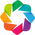

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'d8c18c8f-d196-41f6-8470-45e171318e44': {'version…

In [83]:
gv.extension("bokeh")
df = con.execute("""
SELECT
    longitude AS lon,
    latitude AS lat,
    EXTRACT(EPOCH FROM (COALESCE(closed_date, now()) - created_date)) / 86400 AS open_days
FROM data_6
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

# Non linearity
df["open_days"] = np.log1p(df["open_days"])

points = gv.Points(df, kdims=["lon", "lat"], vdims=["open_days"])
shaded = datashade(
    points,
    aggregator="mean",
    width=1200,
    height=1200,
    cmap=fire,
    cnorm="eq_hist",
    expand=False
)
(gv.tile_sources.CartoDark * shaded).opts(width=400, height=400)

# Service Request times are higher in the periphery—especially the south
# Northwest—while the center is handled faster.
#

#### **Column relationship analysis**


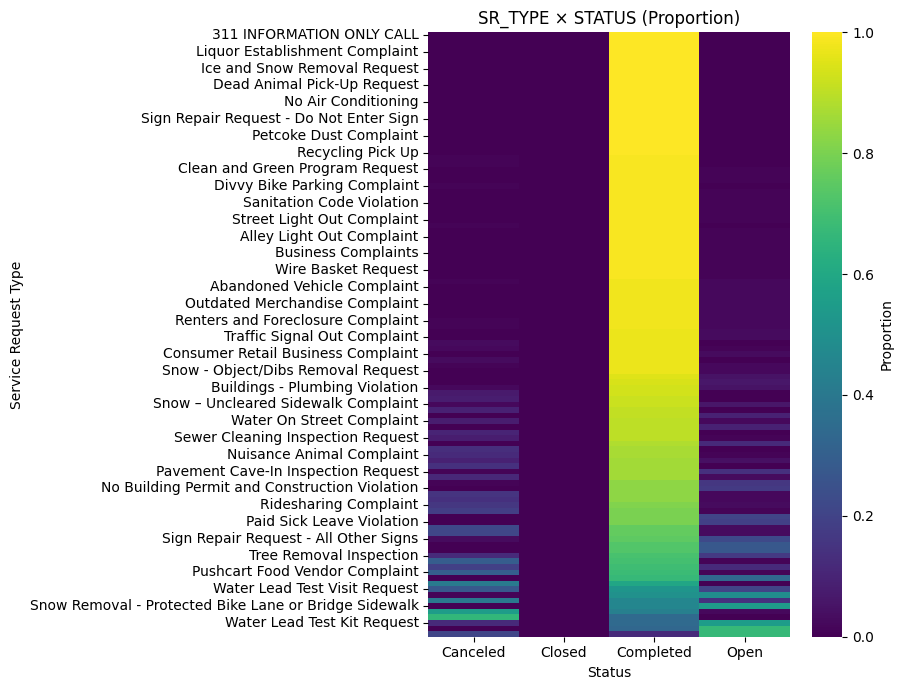

In [84]:
# SR_TYPE × STATUS — heatmap
df_SR_status = con.execute("""
SELECT
    SR_TYPE,
    STATUS,
    COUNT(*) AS n,
    COUNT(*) * 1.0 / SUM(COUNT(*)) OVER (PARTITION BY SR_TYPE) AS pct
FROM data_6
GROUP BY SR_TYPE, STATUS
ORDER BY SR_TYPE, pct DESC
""").df()

df_SR_status["pct"] = df_SR_status["pct"].round(2)

# order by % Completed (ascending)
order = (
    df_SR_status[df_SR_status["STATUS"] == "Completed"]
    .sort_values("pct", ascending=False)["SR_TYPE"]
)

piv = (
    df_SR_status
    .pivot(index="SR_TYPE", columns="STATUS", values="pct")
    .loc[order]
    .fillna(0)
)

plt.figure(figsize=(9, 7))
sns.heatmap(piv, cmap="viridis", annot=False, fmt=".2f", cbar_kws={"label": "Proportion"})
plt.xlabel("Status")
plt.ylabel("Service Request Type")
plt.title("SR_TYPE × STATUS (Proportion)")
plt.tight_layout()
plt.show()

# many SR_TYPES are near-deterministic in outcome ('Completed')
# this high predictability implies limited opportunities for modeling SR_STATUS.
#

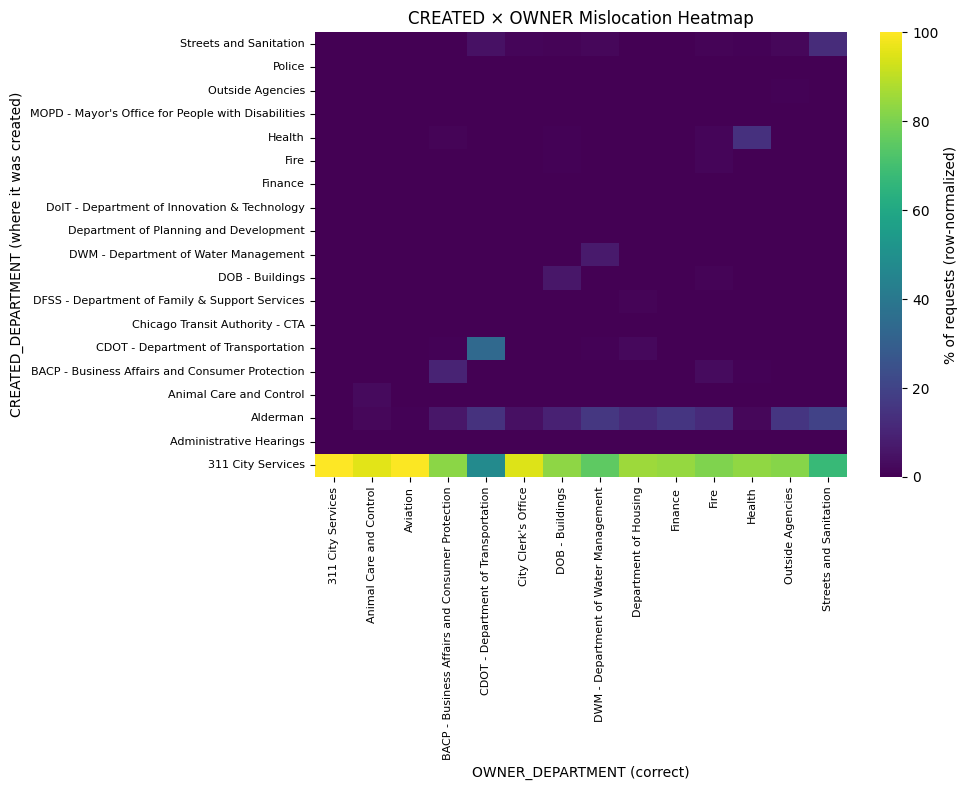

In [85]:
# CREATED × OWNER mislocation heatmap
df_hm = con.execute("""
WITH agg AS (
    SELECT
        OWNER_DEPARTMENT,
        CREATED_DEPARTMENT,
        COUNT(*) AS n
    FROM data_6
    WHERE OWNER_DEPARTMENT IS NOT NULL AND CREATED_DEPARTMENT IS NOT NULL
    GROUP BY 1, 2
),
tot AS (
    SELECT OWNER_DEPARTMENT, SUM(n) AS total_n
    FROM agg
    GROUP BY 1
),
mis AS (
    SELECT
        a.OWNER_DEPARTMENT,
        a.CREATED_DEPARTMENT,
        (a.n * 100.0) / t.total_n AS pct
    FROM agg a
    JOIN tot t
      ON a.OWNER_DEPARTMENT = t.OWNER_DEPARTMENT
),
mis_rate AS (
    SELECT
        OWNER_DEPARTMENT,
        SUM(CASE WHEN CREATED_DEPARTMENT <> OWNER_DEPARTMENT THEN pct ELSE 0 END) AS mis_pct
    FROM mis
    GROUP BY 1
)
SELECT
    m.OWNER_DEPARTMENT,
    m.CREATED_DEPARTMENT,
    m.pct
FROM mis m
JOIN mis_rate r
  ON m.OWNER_DEPARTMENT = r.OWNER_DEPARTMENT
ORDER BY r.mis_pct DESC
""").df()

piv = (
    df_hm
    .pivot(
        index="CREATED_DEPARTMENT",   # Y: where it was created
        columns="OWNER_DEPARTMENT",   # X: correct department
        values="pct"
    )
    .fillna(0)
    .round(1)
)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(piv, cmap="viridis", annot=False, cbar_kws={"label": "% of requests (row-normalized)"})
ax.set_xlabel("OWNER_DEPARTMENT (correct)")
ax.set_ylabel("CREATED_DEPARTMENT (where it was created)")
ax.set_title("CREATED × OWNER Mislocation Heatmap")
ax.invert_yaxis()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# 311 and Alderman receives most of the complaints and direct them to the OWNER department
#

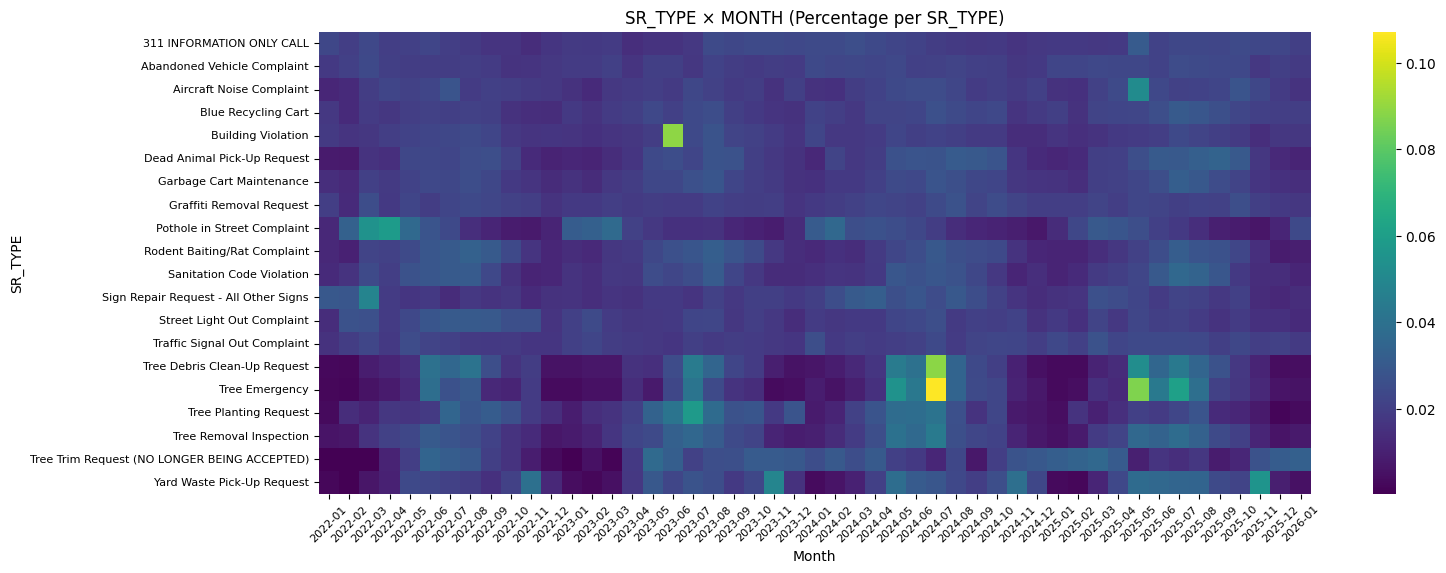

In [86]:
# SR_TYPE × MONTH — heatmap top 20
df = con.execute("""
WITH top_sr AS (
    SELECT SR_TYPE
    FROM data_6
    GROUP BY SR_TYPE
    ORDER BY COUNT(*) DESC
    LIMIT 20
)
SELECT
    d.SR_TYPE,
    STRFTIME(d.CREATED_DATE, '%Y-%m') AS month,
    COUNT(*) AS n
FROM data_6 d
JOIN top_sr t
  ON d.SR_TYPE = t.SR_TYPE
GROUP BY 1, 2
""").df()

# normalize per SR_TYPE (row sums to 1)
piv = (
    df
    .pivot(index="SR_TYPE", columns="month", values="n")
    .fillna(0)
)
piv = piv.div(piv.sum(axis=1), axis=0)

plt.figure(figsize=(16, max(6, 0.3 * len(piv))))
ax = sns.heatmap(piv, cmap="viridis", annot=False)
ax.set_xlabel("Month")
ax.set_ylabel("SR_TYPE")
ax.set_title("SR_TYPE × MONTH (Percentage per SR_TYPE)")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
plt.show()

# Most SR types peak mid-year, consistent with the time-series results
# 'Pothole in the Street' shows an inverted seasonal pattern
# Several SR types exhibit no clear seasonality
#

## **Key Insights**


## **Limitations & Assumptions**


## **Next Steps**


### Feature engineering
- Temporal features: day of week, month, seasonality flags, holidays
- Spatial features: grid cell, hotspot indicator, distance to historical centroids
- Request features: SR_TYPE encoding, department, historical load per SR_TYPE
- Lagged features: recent volume, recent backlog by area and type

---

### Candidate models
- Ranking and prioritization: LambdaMART, LightGBM ranking
- Segmentation: K-Means, Gaussian Mixture Models
- Forecasting: ARIMA, SARIMA, Prophet, Gradient Boosting
- Risk / anomaly: Isolation Forest, One-Class SVM
- Inference

---

### Possible metrics
- Classification: ROC-AUC, PR-AUC, log loss
- Ranking: NDCG@k, MAP@k
- Forecasting: MAE, RMSE, MAPE
- Segmentation: Silhouette score, stability across samples
- Causal / uplift: Qini, AUUC

---

### ML pipeline integration
- Deterministic feature generation (DuckDB / SQL-first)
- Train–validation splits by time
- Experiment tracking and model registry
- Batch inference and periodic retraining
- Monitoring: data drift, performance decay, alerting